# IQ Trajectory + Blob Test (QuTiP Synthetic Data)

`analysis/iq_traj_blobs.py`와 `analysis/iq_blobs.py`를 하드웨어 없이 검증하기 위한 최소 테스트 노트북입니다.
QuTiP로 상태별 readout pointer trajectory를 만들고, 이를 RAW calibration trace처럼 포장해 분석 함수에 넣습니다.

실제 데이터도 IQ 둘다 a.u 로 0.0002 이렇게 작게 찍히는데 뭔 의미인지 확인필요


- chi / kappa ratio 시뮬 필요  
- residual photon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

from laboneq.simple import dsl
from laboneq.dsl.result import AcquiredResult
from laboneq.workflow.tasks.run_experiment import RunExperimentResults

from qpu_types.fixed_transmon.qubit_types import (
    FixedTransmonQubit,
    FixedTransmonQubitParameters,
)
from analysis.iq_traj_blobs import (
    demodulate_time_traces,
    average_chunk_time_traces,
    integrate_shots_for_blobs,
)
from analysis.iq_blobs import (
    fit_data,
    calculate_assignment_matrices,
    calculate_assignment_fidelities,
    plot_iq_blobs,
    plot_assignment_matrices,
)
from analysis.iq_traj import plot_iq_trajectories
from custom_pulse_library import GaussianSquare

plt.rcParams['figure.figsize'] = (6, 4)

from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.deactivate()

In [2]:
1 / (40e-9) *1e-9

0.025

In [19]:
def make_test_qubit(uid='q0', f_lo=7.0e9, f_res=7.05e9):
    return FixedTransmonQubit(
        uid=uid,
        signals={
            'acquire': f'{uid}/acquire',
            'drive': f'{uid}/drive',
            'measure': f'{uid}/measure',
        },
        parameters=FixedTransmonQubitParameters(
            readout_lo_frequency=f_lo,
            readout_resonator_frequency=f_res,
        ),
    )


def sample_readout_gaussian_square_from_qubit(qubit, n_samples, sample_dt_ns=0.5):
    """Sample GaussianSquare envelope from qubit readout pulse parameters."""
    pulse = qubit.parameters.readout_pulse
    if pulse.get('function') != 'GaussianSquare':
        raise ValueError(f"Expected GaussianSquare readout pulse, got {pulse.get('function')!r}.")

    pf = GaussianSquare(
        sigma=pulse.get('sigma'),
        width=pulse.get('width'),
        risefall_sigma_ratio=pulse.get('risefall_sigma_ratio'),
        length=qubit.parameters.readout_length,
    )
    sampling_rate = 1.0 / (sample_dt_ns * 1e-9)
    _, envelope = pf.generate_sampled_pulse(sampling_rate=sampling_rate)
    envelope = np.asarray(envelope, dtype=float)

    if len(envelope) != n_samples:
        x_src = np.linspace(0.0, 1.0, len(envelope), endpoint=False)
        x_dst = np.linspace(0.0, 1.0, n_samples, endpoint=False)
        envelope = np.interp(x_dst, x_src, envelope)

    return qubit.parameters.readout_amplitude * envelope


def simulate_pointer_trace_qutip(
    t_ns,
    state,
    qubit,
    sample_dt_ns=0.5,
    kappa=1 / (40e-9),
    eps_peak=2 * np.pi * 100e6,
    chi=2 * np.pi * 2.3e6,
):
    """Driven damped cavity expectation <a(t)> using GaussianSquare drive."""
    N = 40
    a = qt.destroy(N)
    psi0 = qt.basis(N, 0)
    tlist = t_ns * 1e-9

    state_shift = {'g': -0.5 * chi, 'e': 0.5 * chi, 'f': 1.5 * chi}[state]
    H0 = state_shift * (a.dag() * a)
    Hd = a + a.dag()

    drive_envelope = sample_readout_gaussian_square_from_qubit(
        qubit,
        n_samples=len(t_ns),
        sample_dt_ns=sample_dt_ns,
    )
    drive = eps_peak * drive_envelope
    dt_s = sample_dt_ns * 1e-9

    def drive_coeff(t, _args=None):
        idx = int(np.clip(round(t / dt_s), 0, len(drive) - 1))
        return float(drive[idx])

    c_ops = [np.sqrt(kappa) * a]
    out = qt.mesolve(
        [H0, [Hd, drive_coeff]],
        psi0,
        tlist,
        c_ops,
        [a],
        options={'progress_bar': False},
    )
    return np.asarray(out.expect[0])


def make_synthetic_raw_result(
    qubit,
    states=('g', 'e'),
    n_shots=300,
    n_samples=256,
    sample_dt_ns=0.5,
    if_freq_hz=50e6,
    noise_sigma=0.001,
    seed=42,
):
    rng = np.random.default_rng(seed)
    t_ns = np.arange(n_samples) * sample_dt_ns

    acquired = {}
    base_phase = {'g': 0.2, 'e': 1.0, 'f': 1.8}

    for s in states:
        alpha = simulate_pointer_trace_qutip(
            t_ns,
            s,
            qubit=qubit,
            sample_dt_ns=sample_dt_ns,
        )
        carrier = np.exp(1j * (2 * np.pi * if_freq_hz * t_ns * 1e-9 + base_phase[s]))
        clean = alpha * carrier

        phase_jitter = np.exp(1j * rng.normal(0.0, 0.03, size=(n_shots, 1)))
        amp_jitter = 1.0 + rng.normal(0.0, 0.02, size=(n_shots, 1))
        noise = noise_sigma * (
            rng.normal(size=(n_shots, n_samples))
            + 1j * rng.normal(size=(n_shots, n_samples))
        )

        shots = amp_jitter * phase_jitter * clean[None, :] + noise
        handle = dsl.handles.calibration_trace_handle(qubit.uid, s)
        acquired[handle] = AcquiredResult(
            data=shots,
            axis_name=['shots', 'samples'],
            axis=[np.arange(n_shots), np.arange(n_samples)],
        )

    return RunExperimentResults(acquired_results=acquired)


In [20]:
q = make_test_qubit('q0', f_lo=7.0e9, f_res=7.05e9)
states = ['g', 'e']
sample_dt_ns = 0.5
if_freq_hz = q.parameters.readout_resonator_frequency - q.parameters.readout_lo_frequency

result = make_synthetic_raw_result(
    q,
    states=states,
    n_shots=4000,
    n_samples=2000,
    sample_dt_ns=sample_dt_ns,
    if_freq_hz=if_freq_hz,
    noise_sigma=0.0005,
    seed=7,
)

demod = demodulate_time_traces([q], result, states, sample_dt_ns=sample_dt_ns)
traj = average_chunk_time_traces([q], demod, states, chunk_size=8)
blob = integrate_shots_for_blobs(
    [q],
    demod,
    states,
    integration_start=0,
    integration_stop=2000,
)

fit_results = fit_data([q], blob, fit_method='gmm')
assignment_matrices = calculate_assignment_matrices([q], blob, fit_results)
assignment_fidelities = calculate_assignment_fidelities([q], assignment_matrices)
assignment_fidelities


/var/folders/jr/32xlwr6d0x7cdq4t8l4tq2600000gn/T/ipykernel_85916/2305282944.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  envelope = np.asarray(envelope, dtype=float)
/Users/yalgaeahn/JSAHN/qubit-experiment/.venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


{'q0': np.float64(0.9962500000000001)}

readout_length (ns): 2000.0
readout_amplitude: 1.0
readout_pulse: {'function': 'GaussianSquare', 'sigma': 0.2, 'risefall_sigma_ratio': 3.0, 'can_compress': True}


/var/folders/jr/32xlwr6d0x7cdq4t8l4tq2600000gn/T/ipykernel_85916/2305282944.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  envelope = np.asarray(envelope, dtype=float)


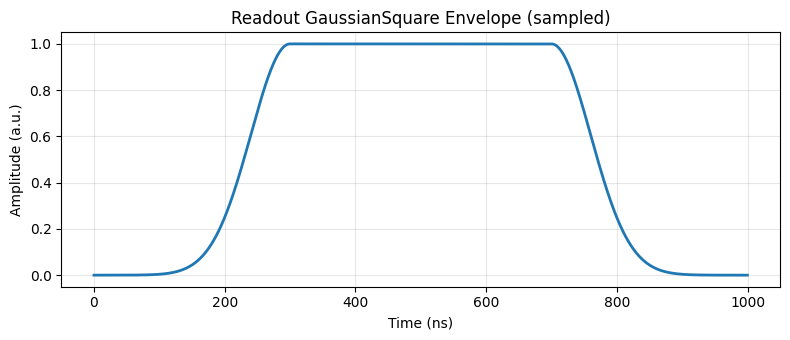

In [21]:
n_samples_plot = 2000
t_ns_plot = np.arange(n_samples_plot) * sample_dt_ns
env = sample_readout_gaussian_square_from_qubit(q, n_samples_plot, sample_dt_ns=sample_dt_ns)

plt.figure(figsize=(8, 3.5))
plt.plot(t_ns_plot, env, lw=2)
plt.title('Readout GaussianSquare Envelope (sampled)')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (a.u.)')
plt.grid(alpha=0.3)
plt.tight_layout()

print('readout_length (ns):', q.parameters.readout_length * 1e9)
print('readout_amplitude:', q.parameters.readout_amplitude)
print('readout_pulse:', q.parameters.readout_pulse)


{'q0': <Figure size 600x400 with 2 Axes>}

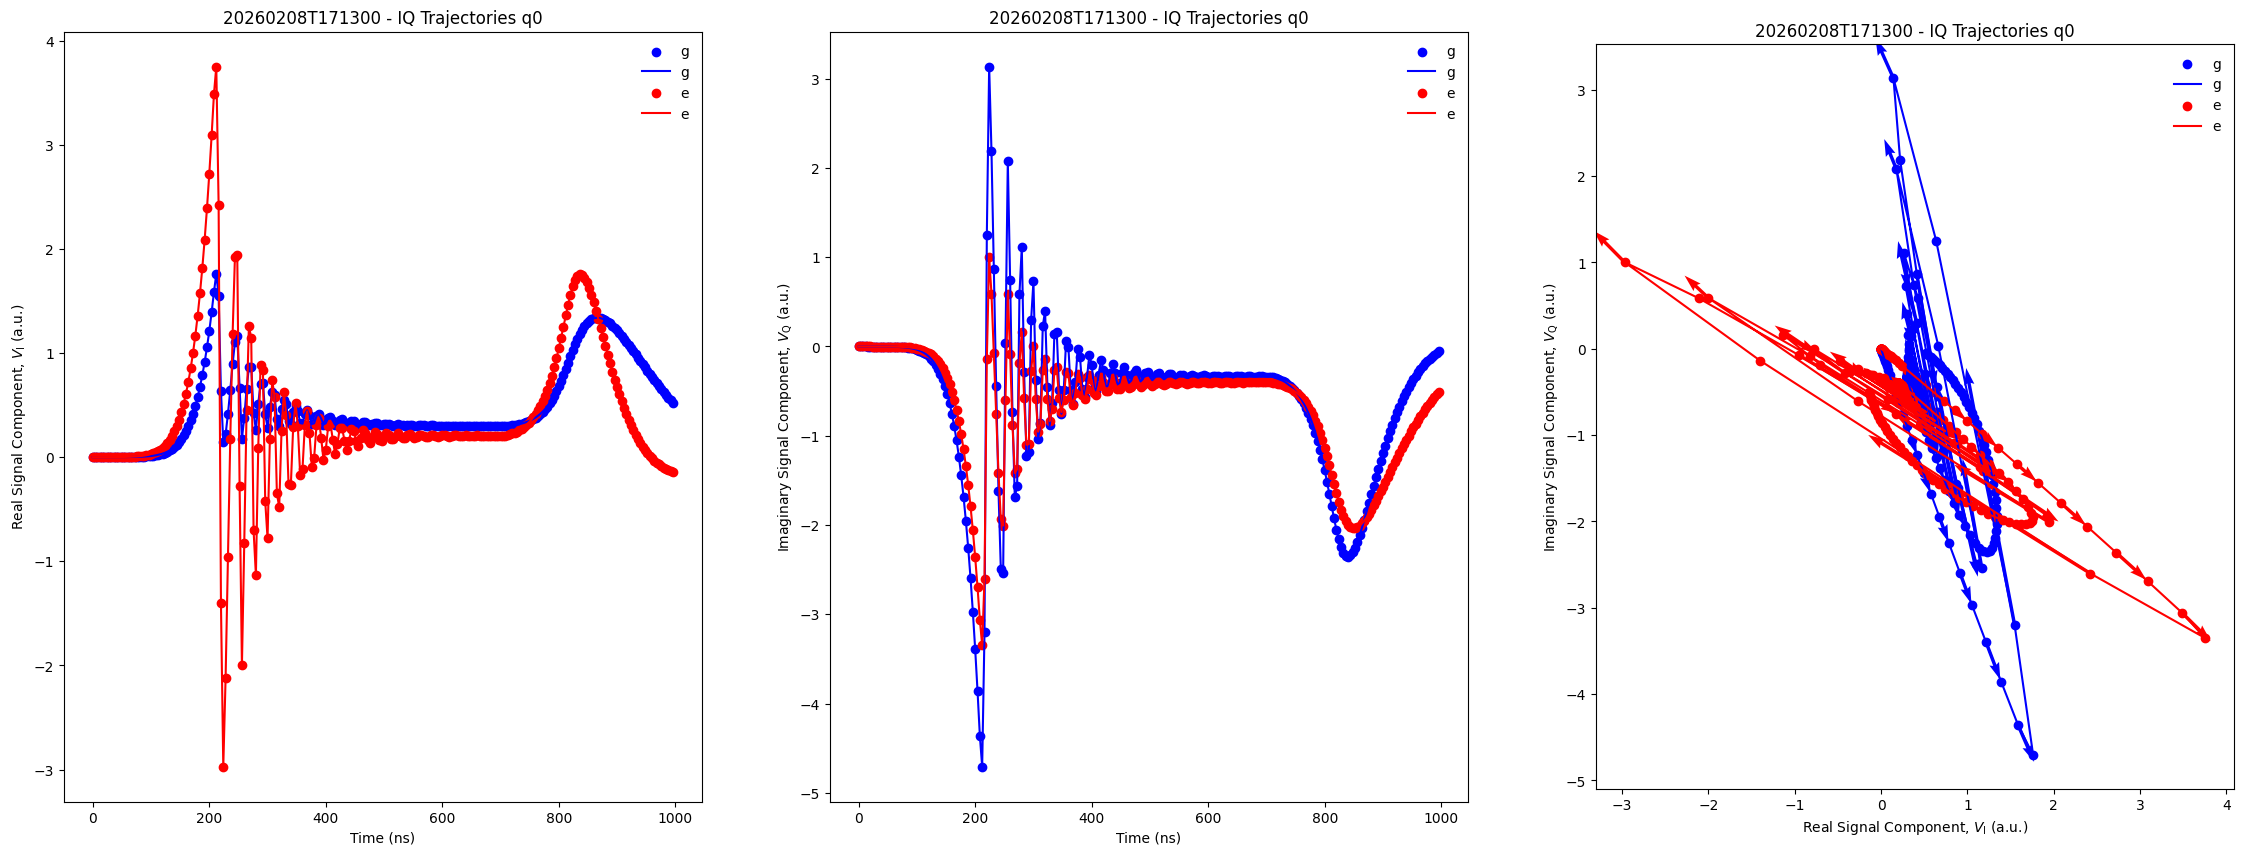

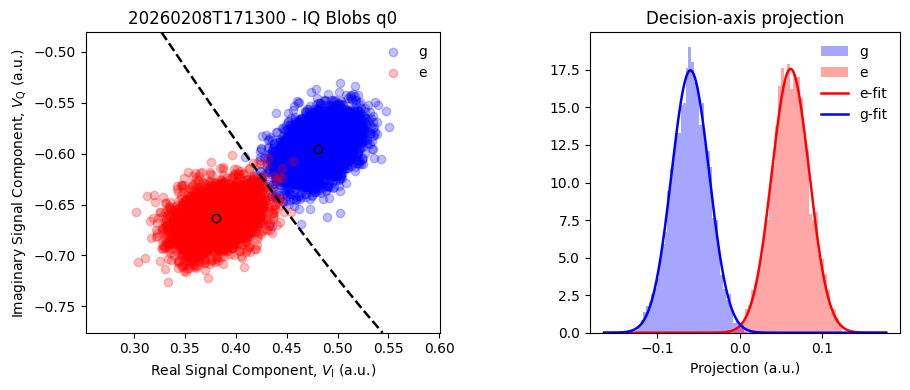

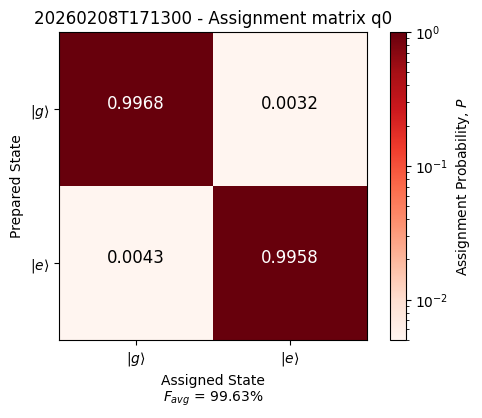

In [22]:
from laboneq_applications.analysis.options import BasePlottingOptions

plot_opts = BasePlottingOptions()
plot_opts.save_figures = False   # 핵심
plot_opts.close_figures = False  # 노트북에서 바로 보려면 권장

plot_iq_trajectories([q], states, traj, chunk_size=8, options=plot_opts)
plot_iq_blobs([q], states, blob, fit_results, options=plot_opts)
plot_assignment_matrices([q], states, assignment_matrices, assignment_fidelities, options=plot_opts)




## Decision-Axis Projection Plot (설명)

IQ blob의 각 샷을 2D 점 $\mathbf{x}=[I,\,Q]^\top$로 두고, 분류 축(unit vector) $\hat{\mathbf{w}}$에 사영하면 1D 좌표로 바뀝니다.

$$
z = \hat{\mathbf{w}}^\top(\mathbf{x}-\boldsymbol{\mu}),\qquad \|\hat{\mathbf{w}}\|=1
$$

여기서 $\boldsymbol{\mu}$는 기준점(예: 전체 평균 또는 클래스 평균)입니다.

선형 판별(2-class)에서는 보통

$$
\hat{\mathbf{w}} \propto \mathbf{\Sigma}^{-1}(\boldsymbol{\mu}_e-\boldsymbol{\mu}_g)
$$

로 축을 잡고, 사영값 $z$의 임계값 $\tau$로 상태를 나눕니다.

$$
z>\tau \Rightarrow e,\qquad z\le \tau \Rightarrow g
$$

Decision-axis projection plot은 각 상태의 $z$ 분포(히스토그램/커널)를 보여주므로,
분포 겹침이 작을수록 readout 분리도와 assignment fidelity가 높다는 뜻입니다.


## 빠른 튜닝 포인트
- 분리도 낮추기: `chi` 감소, `noise_sigma` 증가
- SNR 올리기: `n_shots` 증가, integration window (`integration_start/stop`) 최적화
- 3-state 테스트: `states=['g','e','f']`로 바꾸고 `fit_method='lda'` 사용

참고: `gmm`은 2-state에서 가장 안정적으로 동작합니다.

## (추가) Pointer-State Discrimination: $\kappa/\chi$

Pointer-state 분리 성능은 대체로 cavity linewidth $\kappa$와 dispersive pull $\chi$의 비율에 좌우됩니다.

$$
\alpha_s = -\frac{i\,\varepsilon}{\frac{\kappa}{2}+i\Delta_s},\qquad \Delta_{e,g}=\Delta_c\mp\chi
$$

두 상태 분리도:

$$
D = |\alpha_e-\alpha_g|
$$

on-resonance ($\Delta_c=0$) 근사에서:

$$
|\alpha_e-\alpha_g| \propto \frac{\chi}{(\kappa/2)^2+\chi^2}.
$$

따라서 일반적으로 $\kappa/\chi$가 작을수록 IQ 분리가 유리합니다.

또한 대표적으로

$$
\Gamma_{\mathrm{meas}} \sim \frac{8\chi^2}{\kappa}\,\bar{n}
$$

이므로 (정의별 상수 차이 제외) 같은 $\bar n$에서 $\chi^2/\kappa$가 클수록 discrimination이 좋아집니다.
